# Section 5.5: Empirical application, job training program

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegressionCV, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from ml4econometrics.ols import OLS
from ml4econometrics.penalized_regressions import Lasso, LogitLasso, BCHLasso
from ml4econometrics.pipelines import standardize

In [2]:
#------------------------------------------------------
# ATT function
#------------------------------------------------------
def att(y, d, y_hat, d_hat, group_idx=None):
    """
    att:
        Compute average treatment effect estimator,
        and its standard error.
    Args:
        y (np.array): outcome.
        d (np.array): Treatment status.
        y_hat (np.array): Prediction of Y from X.
        d_hat (np.array): Propensity score.
        group_idx (np.array): Group indicator.
    """
    gamma = np.empty_like(y)
    if group_idx is not None:
        y = y[group_idx]
        d = d[group_idx]
        y_hat = y_hat[group_idx]
        d_hat = d_hat[group_idx]

    pi = d.mean()
    gamma[group_idx] = (d - (1 - d) * d_hat / (1 - d_hat)) * (y - y_hat) / pi
    gamma[~group_idx] = np.nan
    return gamma

# Data

In [3]:
COLUMNS = [
    "treated",
    "age",
    "education",
    "black",
    "hispanic",
    "married",
    "nodegree",
    "re74",
    "re75",
    "re78",
]

COVARIATES = ["age", "education", "black", "hispanic", "married", "nodegree", "re74", "re75", "noincome74", "noincome74"]

FILES = {
    "treated": "http://www.nber.org/~rdehejia/data/nswre74_treated.txt",
    "experimental": "http://www.nber.org/~rdehejia/data/nswre74_control.txt",
    "psid": "http://www.nber.org/~rdehejia/data/psid_controls.txt"
}

df = pd.concat([
    (
        pd.read_csv(v, sep=r"\s+", names=COLUMNS)
        .assign(sample = k)
        .assign(noincome74 = lambda x: 1*(x["re74"] == 0))
        .assign(noincome75 = lambda x: 1*(x["re75"] == 0))
        ) for k, v in FILES.items()
], axis=0).reset_index(drop=True)

df["sample"].value_counts()

sample
psid            2490
experimental     260
treated          185
Name: count, dtype: int64

# Baseline: experimental estimator

In [4]:
y = df.query("sample in ('treated', 'experimental')")["re78"].values
d = df.query("sample in ('treated', 'experimental')")["treated"].values

ols = OLS()
ols.fit(d.reshape(-1, 1), y)
ols.compute_std(d.reshape(-1, 1), y, robust=False)

print(f"Experimental estimate is {ols.coef_[0]:.2f} USD with an std of {ols.std[1]:.2f} USD.")

Experimental estimate is 1794.34 USD with an std of 632.14 USD.


# Data preparation

## Feature transformation

Shape after transformation: (2675, 189).
Shape after removing constant features: (2675, 183).
Number of zero singular values: 0.


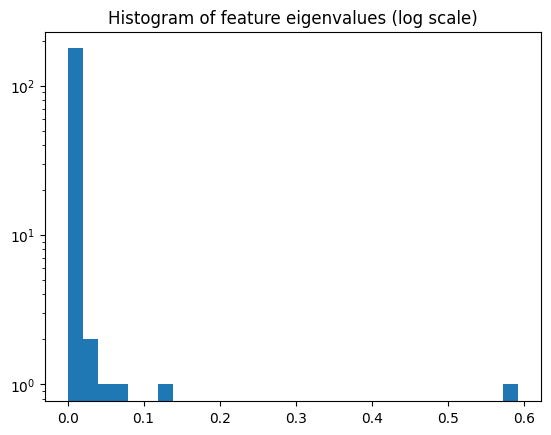

In [5]:
pipe = ColumnTransformer([
    (
        'continuous',
        Pipeline([
            ("polynomial", PolynomialFeatures(degree=5)),
            ("min_max_scaler", MinMaxScaler())
        ]),
        ["age", "education", "re74", "re75"]
    ),
    (
        'interactions',
        Pipeline([
            ("polynomial", PolynomialFeatures(degree=2, interaction_only=True)),
            ("min_max_scaler", MinMaxScaler())
        ]),
        COVARIATES
    ),
    (
        'discrete',
        Pipeline([
            ("polynomial", PolynomialFeatures(degree=1, interaction_only=False)),
        ]),
        ['black', 'hispanic', 'married', 'nodegree', 'noincome74', 'noincome75']
    )
])
X = pipe.fit_transform(df.query("sample in ('treated', 'psid')"))
print(f"Shape after transformation: {X.shape}.")

X = X[:, X.std(axis=0) != 0]
print(f"Shape after removing constant features: {X.shape}.")

u, w, vt = np.linalg.svd(X)
e_ = w ** 2
e_ /= e_.sum()

_ = plt.hist(e_, bins=30, log=True)
plt.title("Histogram of feature eigenvalues (log scale)")
print(f"Number of zero singular values: {(e_==0).sum():.0f}.")

In [15]:
y = df.query("sample in ('treated', 'psid')")["re78"].values
std_y = y.std()
mean_y = y.mean()
y = (y - mean_y) / std_y

d = df.query("sample in ('treated', 'psid')")["treated"].astype("int").values

## Folds

In [16]:
n = len(X)
n_folds = 5   # nb folds
np.random.seed(99999)

# Generate random split
cvgroup = np.digitize(np.random.rand(n), np.linspace(0, 1, n_folds + 1))

## Estimators

In [11]:
estimators ={
    "farrell (2015)": {
        "treatment": Lasso(max_iter=10_000),
        "outcome": LogitLasso(max_iter=10_000)
    },
    "ridge cv": {
        "treatment": LogisticRegressionCV(max_iter=5_000, penalty="l2"),
        "outcome": RidgeCV()
    },
    "lasso cv": {
        "treatment": LogisticRegressionCV(max_iter=5_000, penalty="l1", solver="liblinear"),
        "outcome": LassoCV(max_iter=5_000)
    },
    "random forest": {
        "treatment": RandomForestRegressor(n_estimators=500, min_samples_split=5),
        "outcome": RandomForestRegressor(n_estimators=500, min_samples_split=5)
    },
    "gradient boosting": {
        "treatment": GradientBoostingRegressor(n_estimators=500, min_samples_split=5),
        "outcome": GradientBoostingRegressor(n_estimators=500, min_samples_split=5)
    },
}

# Double ML with cross-fitting

In [17]:
gamma = {}
for k in tqdm(range(1, n_folds + 1)):
    # Partition according to the group
    Ik = (cvgroup == k)
    NIk = (cvgroup != k)

    # Fit and predict for each method
    for method, v in estimators.items():
        v["treatment"].fit(X[NIk], d[NIk])
        if hasattr(v["treatment"], "predict_proba"):
            d_hat = v["treatment"].predict_proba(X[Ik])[:, 1]
        else:
            d_hat = v["treatment"].predict(X[Ik])
        cs = (d_hat >= .01) & (d_hat <= .99)

        v["outcome"].fit(X[NIk], y[NIk])
        y_hat = v["treatment"].predict(X[Ik])

        if k == 1:
            gamma[method] = [att(y[Ik], d[Ik], y_hat, d_hat, group_idx=cs)]
        else:
            gamma[method].append(att(y[Ik], d[Ik], y_hat, d_hat, group_idx=cs))

gamma = pd.DataFrame({k: np.concatenate(v) for k, v in gamma.items()})


 40%|████      | 2/5 [01:18<01:58, 39.45s/it]/var/folders/2g/fw85b20s4zl1k7229pd39y5c0000gn/T/ipykernel_8264/3632210498.py:23: RuntimeWarning: Mean of empty slice.
  pi = d.mean()
/Users/jeremylhour/opt/anaconda3/envs/ml4econometrics/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 60%|██████    | 3/5 [02:06<01:26, 43.19s/it]/var/folders/2g/fw85b20s4zl1k7229pd39y5c0000gn/T/ipykernel_8264/3632210498.py:23: RuntimeWarning: Mean of empty slice.
  pi = d.mean()
/Users/jeremylhour/opt/anaconda3/envs/ml4econometrics/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 80%|████████  | 4/5 [02:58<00:46, 46.79s/it]/var/folders/2g/fw85b20s4zl1k7229pd39y5c0000gn/T/ipykernel_8264/3632210498.py:23: RuntimeWarning: Mean of empty slice.
  pi = d.mean()
/Users/jeremylhour/opt/anaconda3/envs/ml4econo

In [14]:
table = {
    'ATT': gamma.mean(),
    'std': gamma.std() / np.sqrt(gamma.notna().sum()),
    'effective sample size': gamma.notna().sum()
}
pd.DataFrame(table).T

,farrell (2015),ridge cv,lasso cv
ATT,2820.433015,838.941620,-5916.537155
std,1697.226621,977.934513,914.026496
effective sample size,1084.000000,1510.000000,2360.000000
